## 营销广告效果分析

数据集地址：https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

数据集说明：  
&emsp;&emsp;市场营销公司希望成功运营营销活动，但是市场环境复杂，有多种活动方案可供选择。通常会进行小流量测试（A/B test),用一个随机试验，将不同版本的不同变量(网页，页面元素，横幅等)同时展示给不同的人群，以确定哪个版本的影响最大，并驱动业务指标。  
&emsp;&emsp;营销广告实验分为两组，大多数人会接触到广告(实验组)。而一小部分人(对照组)会看到一个位置、大小和实验组相同的公益公告(PSA)(或者什么都没有)。这个数据集的目的是分析这些群体，判断广告是否成功，公司能从广告中赚多少钱，以及这些群体之间的差异是否具有统计学意义。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
marketing_AB = pd.read_csv('/marketing_AB.csv')

In [3]:
marketing_AB.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### 数据清洗

In [4]:
# 检测数据缺失情况
marketing_AB.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [5]:
# 检测重复数据,整行重复，用户数据重复
marketing_AB.duplicated().any()
marketing_AB.duplicated('user id').any()
# marketing_AB.is_unique

False

In [6]:
marketing_AB.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [7]:
marketing_AB.rename({'user id': 'user_id', 'test group': 'test_group', 'total ads': 'total_ads',
                     'most ads day': 'most_ads_day', 'most ads hour': 'most_ads_hour'}, axis=1, inplace=True)

In [8]:
marketing_AB.dtypes

user_id           int64
test_group       object
converted          bool
total_ads         int64
most_ads_day     object
most_ads_hour     int64
dtype: object

In [9]:
marketing_AB = marketing_AB.astype({'user_id': 'str', 'test_group': 'str', 'most_ads_day': 'str'}, copy=False)

### 数据探索

In [10]:
# 实验组用户看到广告，为控制组用户展示公益广告或者为空，经过探索发现，most_ads_day、most_ads_hour在两组中并无差异，符合预期，认为用户分流符合要求，
# 实验指标为购买产品的比例，购买产品用户数/各组相对用户数，也即A/B test二类指标。
# 数据探索，大致上看看有无差异
ad_psa = marketing_AB.loc[:, ['test_group', 'converted']].groupby(by='test_group').agg(
    ['count', 'sum'])

In [11]:
ad_psa

converted       
               count    sum
test_group                 
ad            564577  14423
psa            23524    420

In [12]:
ad_psa = ad_psa.droplevel(level=0, axis=1).reset_index()
ad_psa.rename({'count': 'user_num', 'sum': 'pay_num'}, axis=1, inplace=True)

In [13]:
ad_psa['buy_ratio'] = ad_psa['pay_num'] / ad_psa['user_num'] #购买率

In [14]:
ad_psa

,test_group,user_num,pay_num,buy_ratio
0,ad,564577,14423,0.025547
1,psa,23524,420,0.017854


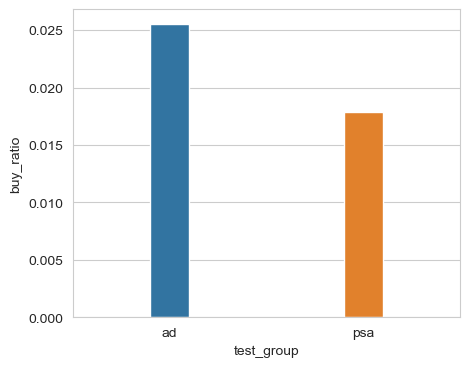

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(5, 4))
sns.barplot(data=ad_psa, x='test_group', y='buy_ratio', errorbar='sd', width=0.2)
plt.show()

### 假设检验

检验原理：https://www.jianshu.com/p/67fae42e6298

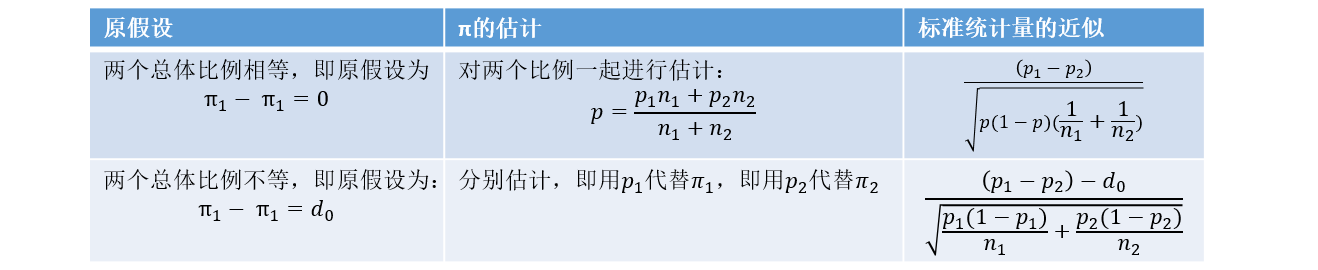

In [16]:
from IPython.display import Image
Image(filename = '/检验原理.png',)

In [17]:
# 设置广告组(ad)购买率为Pa,公益广告(psa)组购买率为Pb
# 原假设(H0): Pa - Pb <= 0
# 备择假设(H1): Pa - Pb > 0

In [18]:
# 总体比例未知且不相等，右侧检验，设置D0=0.001
D0 = 0.001
Pa = ad_psa.loc[ad_psa['test_group'] == 'ad', 'buy_ratio'].values
Pb = ad_psa.loc[ad_psa['test_group'] == 'psa', 'buy_ratio'].values
Na = ad_psa.loc[ad_psa['test_group'] == 'ad', 'user_num'].values
Nb = ad_psa.loc[ad_psa['test_group'] == 'psa', 'user_num'].values
statistic_z = (Pa - Pb - D0) / np.sqrt(Pa * (1 - Pa) / Na + Pb * (1 - Pb) / Nb) #检验统计量
p_value = 1 - stats.norm.cdf(statistic_z, 0, 1) #p值

In [19]:
print('统计量为{0},P值为{1},P值小于给定显著性水平0.05，备择假设成立，即看到广告组的用户购买率更高'.format(statistic_z,
                                                                                                        p_value))

统计量为[7.53190402],P值为[2.49800181e-14],P值小于给定显著性水平0.05，备择假设成立，即看到广告组的用户购买率更高


### 总结

&emsp;&emsp;A/B test实验的样本量确定，实验对一类指标的影响（保证二类指标提升带来的收益大于一类指标下降引起损失）都需要进行分析，
项目背景未确定统计效力、实验误差，数据源没有一类指标相关数据，故未做相关分析